# 在平坦表面上模拟细菌菌落的生长与传播：分支菌落
该协议与模拟圆形菌落的协议完全相同，只是在COMETS模型中改动了几处参数，使得菌落呈现出分支生长的特征。

In [2]:
import cobra
import cobra.io # for the ijo1366 model
import sys
import numpy as np
#sys.path.append("/home/jeremy/Dropbox/work_related/harcombe_lab/segre/cometspy")
import cometspy as c

首先，让我们使用cobrapy的功能制作一个“toy”模型。它直接将细胞外碳转化为生物质。

In [3]:
carbon = cobra.Metabolite("carbon",
                           compartment = "e")
carbon_exch = cobra.Reaction("Carbon_exch",
                            lower_bound = -1.,
                            upper_bound = 1000.)
carbon_exch.add_metabolites({carbon: -1.})
Biomass = cobra.Reaction("Biomass",
                        lower_bound = 0.,
                        upper_bound = 1000.)
Biomass.add_metabolites({carbon: -1.})
toy = cobra.Model("toy")
toy.add_reactions([carbon_exch, Biomass])
toy.objective = "Biomass"
toy.repair()

我们可以通过在cobrapy中进行FBA（ Flux Balance Analysis）测试来验证模型能否运行。理论上，模型应能生成不低于碳交换通量下限的生物量（carbon_exch）。

In [4]:
print(toy.medium)
print(toy.optimize().objective_value)

{'Carbon_exch': 1.0}
1.0


我们现在将此模型转化为COMETS模型，并设置其初始生物量，以及第一组对流参数。这些参数是为了使用该简化模型获得分支状菌落所必需的。请注意，对于这种形式的生物量扩散，需要将时间步长设置得非常小。

In [5]:
grid_size = 30

toy_comets = c.model(toy)
toy_comets.initial_pop = [int(grid_size / 2),int(grid_size / 2),1.0]
toy_comets.open_exchanges()
toy_comets.add_convection_parameters(packedDensity = 1.2,
                                    elasticModulus = 5.e-3,
                                    frictionConstant = 1.0,
                                    convDiffConstant = 0.0)
toy_comets.add_noise_variance_parameter(20.)

C:\Users\99374\.conda\envs\CarveMe\Lib\site-packages\cometspy\model.py:623: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.smat = pd.concat([self.smat, cdf])
C:\Users\99374\.conda\envs\CarveMe\Lib\site-packages\cometspy\model.py:636: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


我们要确保COMETS模型不将生物量反应视为交换反应。

In [6]:
toy_comets.reactions.loc[toy_comets.reactions.REACTION_NAMES == "Biomass","EXCH"] = False
toy_comets.reactions.loc[toy_comets.reactions.REACTION_NAMES == "Biomass","EXCH_IND"] = 0
toy_comets.reactions.loc[toy_comets.reactions.REACTION_NAMES == "Biomass", "LB"] = 0

此次模拟的布局是在100x100网格上构建一个居中单一群落。碳源会在该区域内均匀分布。

In [7]:
ly = c.layout([toy_comets])
ly.grid = [grid_size, grid_size]
ly.set_specific_metabolite("carbon", 1.)

C:\Users\99374\.conda\envs\CarveMe\Lib\site-packages\cometspy\layout.py:1361: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.media = pd.concat([self.media, new_row],


我们需要设置的关键参数是“biomassmotionstyle”，必须将其设置为“Convection 2D”。接下来，为了捕获空间信息，我们将记录生物量的具体分布（而不只是记录总体生物量）。最后，我们还会调整一些其他的参数。这些参数都存储在名为all_params的字典中。

In [8]:
p = c.params()

p.all_params["biomassMotionStyle"] = "Convection 2D"
p.all_params["writeBiomassLog"] = True
p.all_params["BiomassLogRate"] = 500
p.all_params["maxCycles"] = 20000
p.all_params["timeStep"] = 0.00025
p.all_params["spaceWidth"] = 1
p.all_params["maxSpaceBiomass"] = 10
p.all_params["minSpaceBiomass"] = 0.25e-10
p.all_params["allowCellOverlap"] = True
p.all_params["growthDiffRate"] = 0
p.all_params["flowDiffRate"] = 3e-9
p.all_params["exchangestyle"] = "Monod Style"
p.all_params["defaultKm"] = 0.01
p.all_params["defaultHill"] = 1
p.all_params["defaultVmax"] = 100

现在我们制作一个模拟对象并运行它。这可能需要一段时间。

In [9]:
sim = c.comets(ly, p)
# this should all be removable once the installer is made with dependencies in a predictable location
sim.set_classpath("concurrent", "/opt/colt/lib/concurrent.jar")
sim.set_classpath("colt", "/opt/colt/lib/colt.jar")
sim.set_classpath("lang3", "/opt/commons-lang3-3.9/commons-lang3-3.9.jar")
sim.set_classpath("jmatio","/opt/jmatio/lib/jmatio.jar")
sim.set_classpath("math3","/opt/commons-math3-3.6.1/commons-math3-3.6.1.jar")
sim.set_classpath("bin","/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_2.10.0.jar")
sim.set_classpath("gurobi","/opt/gurobi900/linux64/lib/gurobi.jar")
sim.set_classpath("jdistlib", "/opt/jdistlib-0.4.5-bin.jar")

sim.run(False) # use the argument delete_files = False to keep all COMETS-generated files


Running COMETS simulation ...
Done!


现在让我们绘制出结果。注意我们在指定轴标签时的操作，如果不明确指定，则会默认认为“cycle”、“x”和“y”是状态变量。

我们观察到两种物种都能存活下来，这是因为LCTStex_KO突变体通过交叉喂养从galE_KO突变体那里获取半乳糖，而galE_KO突变体则利用乳糖中的葡萄糖部分。当达到平衡时，代谢产物正如在恒化器中的典型情况一样，浓度非常低。

C:\Users\99374\AppData\Local\Temp\ipykernel_112\1080893268.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = matplotlib.cm.get_cmap("copper")


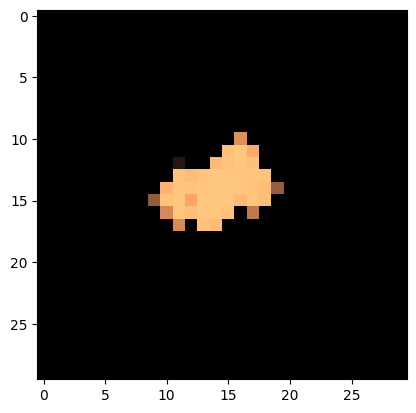

In [10]:
im = sim.get_biomass_image('toy', 1500)
from matplotlib import pyplot as plt
import matplotlib.colors, matplotlib.cm
my_cmap = matplotlib.cm.get_cmap("copper")
my_cmap.set_bad((0,0,0))
plt.imshow(im, norm = matplotlib.colors.LogNorm(), cmap = my_cmap)

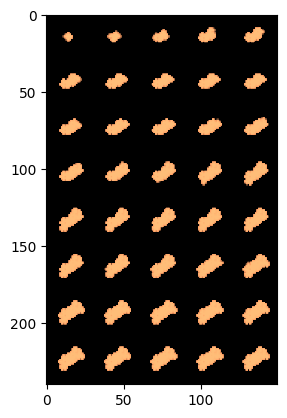

In [11]:
big_image = np.zeros((grid_size * 8, grid_size * 5))
im_cycles = np.arange(p.all_params["BiomassLogRate"], p.all_params["maxCycles"] + p.all_params["BiomassLogRate"],
                      p.all_params["BiomassLogRate"])
for i, cycle in enumerate(im_cycles):
    big_image[(grid_size * int(i / 5)):(grid_size + grid_size * int(i / 5)),(grid_size * (i % 5)):(grid_size + grid_size * (i % 5))] = sim.get_biomass_image("toy", cycle)
    plt.imshow(big_image, norm = matplotlib.colors.LogNorm(), cmap = my_cmap)